# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import warnings
from constants import *
import math
import random
import matplotlib.pyplot as plt
import dill

# Helper Methods

In [52]:
def generate_random_sample(X, size):
    '''
    Given a list X, 
    generate random samples of given size
    '''
    Z_temp = random.sample(list(X), size)
    
    #Concatenation
    Z = [Z_temp[0]]
    for val in Z_temp[1:]:
        Z = np.concatenate([Z,[val]])
    
    return Z

def convert_values_to_list(list_val):
    '''
    Given a list X = [1 2 3] , 
    return X = [[1],[2],[3]]
    '''
    X = []
    for i in list_val:
        X.append([i])
    return X

def conversion_list_of_list(X, DIMENSION):
    '''
    Given a list X with values in lists,
    X = [[ 3  2  2],[4 8 10]]
    Convert each value to a list
    Return list of lists, array of lengths of each sequence
    X = [[3] [2] [2] [4] [8] [10]]
    ''' 
    X_new = []
    length = len(X)
    for idx, val_list in enumerate(X):
        Y = []
        for val in val_list:
            Y.append([val])
        X_new.append(Y)

    #Concatenation
    Z = X_new[0]
    for val_list in X_new[1:]:
        Z = np.concatenate([Z,val_list])

    # assign array of lengths for HMM
    lengths = [DIMENSION]*length
    
    return Z,lengths

#Calculate likelihood for given sequence according to given HMMs and return HMM
def likelihood_sequence(sequence, HMM_array):
    '''
    Given list of K HMMs and sequence,
    determines likelihood of sequence under all HMM models
    Returns index of HMM which has max likelihood
    ''' 
    scores = []
    length = [len(sequence)]
    for i, HMM in enumerate(HMM_array):
        calculated_score = HMM.score(sequence, length)
        scores.append(calculated_score)
    idx = scores.index(max(scores))
    return idx

def HMM_model_stats(model):
    '''
    Details of HMM model
    ''' 
    print("*************************************")
    print("Transition matrix")
    print(model.transmat_)
    print("*************************************")
    print("Means and stds of each hidden state")
    for i in range(model.n_components):
        print("Hidden state {0}".format(i))
        print("mean = ", model.means_[i])
        print("cov = ", model.covars_[i])
        print()

def BIC(model,X,lengths):
    LogLikelihood = model.score(X,lengths)
    num_hidden_states = model.n_components
    # D counts transition matrix (emission estimated by PDF), means = num_hidden_states  
    # covariance matrix = num_hidden_states
    D = num_hidden_states*(num_hidden_states-1)+ 2*num_hidden_states
    BIC = LogLikelihood - (D/2)*np.log(len(X))
    return BIC
    
def BIC_array(HMM_array,X_i):
    BIC_total = 0
    for i in range(len(X_i)):
        model = HMM_array[i]
        X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        BIC_total+= BIC(model,X,lengths)
    return BIC_total

def likelihood_array(HMM_array,X_i):
    likelihood_total = 0
    for i in range(len(X_i)):
        if(len(X_i[i])>=HMM_array[i].n_components):
            model = HMM_array[i]
            X, lengths = conversion_list_of_list(X_i[i],DIMENSION)
            LogLikelihood = model.score(X,lengths)
            likelihood = LogLikelihood 
            likelihood_total+= likelihood
    return likelihood_total

def plot_BIC(list_k, BIC_score):
    fig = plt.subplot(111)
    plt.plot(list_k, BIC_score, marker='o')  
    plt.xlabel('Value of K')
    plt.ylabel('Objective')
    plt.title('BIC')
    plt.show() 

def print_stats(assignments,length):
    for i in range(length):
        if(i%100==0):
            print(assignments[i])   

# Load Data and Clean

In [3]:
df = pd.read_csv('RPKMOutput/RNASeq.txt', sep="\t", na_values=['-'])
df = df.dropna()
df = df[['AccNum','GeneName','cdReads0','cdReads1','cdReads2','cdReads3','cdReads4','cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']]



# Filter cdReads

In [4]:
df = df[(df['cdReads0'] >= 10) & (df['cdReads1'] >= 10) & (df['cdReads2'] >= 10)& (df['cdReads3'] >= 10)& (df['cdReads4'] >= 10)]

In [5]:
#Dataset
df_main = df[['cdRPKM0','cdRPKM1','cdRPKM2','cdRPKM3','cdRPKM4']]
LENGTH,DIMENSION = df_main.shape
print("Dataset size is",LENGTH)
print("Features are", DIMENSION)
print(df_main.head(5))
X = np.log2(df_main.values)
print("****************************")
print("First 5 log2 values\n",X[:5])

Dataset size is 10340
Features are 5
     cdRPKM0    cdRPKM1    cdRPKM2    cdRPKM3    cdRPKM4
0   6.642349   5.591876   6.004645   5.369988   8.507454
2   8.115351   9.879314   9.263817   7.164127   7.730539
3  54.937502  55.371390  64.913315  67.172940  78.293873
5  49.166094  35.735701  40.321640  35.461616  35.952554
8  35.030842  32.456656  35.944257  37.945878  41.572410
****************************
First 5 log2 values
 [[ 2.7316935   2.48333227  2.58607888  2.42491875  3.08872747]
 [ 3.02065354  3.30441091  3.21160671  2.8407909   2.95056898]
 [ 5.7797194   5.79106884  6.02044253  6.06980827  6.29082751]
 [ 5.61959185  5.1592942   5.33348242  5.1481864   5.16802236]
 [ 5.13055377  5.02044247  5.16768936  5.24587127  5.37755449]]



# BIC Determination

In [53]:
X_temp, lengths = conversion_list_of_list(X,DIMENSION)
BIC_array = []
for i in range(1,4):
    print("processing",i)
    model = hmm.GaussianHMM(n_components=i,covariance_type='full')
    model.fit(X_temp,lengths)
    HMM_model_stats(model)
    print("processing",i,"done")


processing 1
*************************************
Transition matrix
[[ 1.]]
*************************************
Means and stds of each hidden state
Hidden state 0
mean =  [ 4.07492855]
cov =  [[ 3.45428767]]

processing 1 done
processing 2
*************************************
Transition matrix
[[  9.99998013e-01   1.98681804e-06]
 [  2.27606141e-06   9.99997724e-01]]
*************************************
Means and stds of each hidden state
Hidden state 0
mean =  [ 2.70433816]
cov =  [[ 1.15841379]]

Hidden state 1
mean =  [ 5.61686644]
cov =  [[ 1.54624819]]

processing 2 done
processing 3
*************************************
Transition matrix
[[  9.99986873e-01   4.42515335e-16   1.31271186e-05]
 [  1.05582654e-14   9.99881015e-01   1.18985323e-04]
 [  2.32600101e-05   2.11909541e-04   9.99764830e-01]]
*************************************
Means and stds of each hidden state
Hidden state 0
mean =  [ 6.26078874]
cov =  [[ 1.28847077]]

Hidden state 1
mean =  [ 2.16756947]
cov =  [

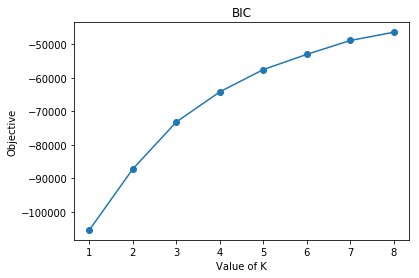

In [18]:
plot_BIC(range(1,9),BIC_array,)

In [23]:
for i in range(1,9):
    print("Increase at",i,BIC_array[i]-BIC_array[i-1])
    

Increase at 1 18245.1043676
Increase at 2 14001.094016
Increase at 3 9006.43592471
Increase at 4 6643.25019279
Increase at 5 4538.00958381
Increase at 6 4152.63436922
Increase at 7 2459.10151062


# Arrays with HMM models for 1<=K<=20

In [6]:
HMM_K_ARRAYS = []
X_i_K_ARRAYS = []

# Check likelihood and do assignments

In [7]:
K_values = [18]

In [11]:
for K in K_values:
    HMM_array = []
    X_i = []
    print("**************** K =", K ,"************************")
    for i in range(K):
        X_i.append([])
        
    NUM_ITERATIONS = 0
    NUM_CLUSTER_PREV = {}
    NUM_CLUSTER_NOW = {}
    
    # Sequences for initial HMM estimation
    # Make K subsets data of LENGTH
    for i in range(LENGTH):
        for j in range(K):
            if(i%K==j):
                X_i[j].append(list(X[i]))
                NUM_CLUSTER_PREV[i] = j
                
    for i in range(K):
        model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
        X_temp, lengths = conversion_list_of_list(X_i[i],DIMENSION)
        model.fit(X_temp, lengths)
        HMM_array.append(model)
    
    likelihood_prev = likelihood_array(HMM_array,X_i)
    print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_prev)
    NUM_ITERATIONS+=1
    while (True):
        # Assign all sequences to HMM models

        print("************ Check likelihood of sequence in HMM  *********")
        NUM_CLUSTER_NOW = {}
        for idx,x in enumerate(X):
            sequence = convert_values_to_list(x)
            hmm_index = likelihood_sequence(sequence, HMM_array)
            X_i[hmm_index].append(list(x))
            NUM_CLUSTER_NOW[idx] = hmm_index
        print("************ Checking likelihood done  *********")

        # Re-estimate parameters for new HMMs
        print("************ Re-estimating HMM *********")
        HMM_array_prev = HMM_array
        HMM_array = []
        for i in range(K):
            model = hmm.GaussianHMM(n_components=3,covariance_type='diag')
            if(len(X_i[i])>=model.n_components):
                X_temp, lengths = conversion_list_of_list(X_i[i], DIMENSION)
                model.fit(X_temp, lengths)
                HMM_array.append(model)
            else:
                HMM_array.append(HMM_array_prev[i])
        print("************ Re-estimation done *********")
        likelihood_curr = likelihood_array(HMM_array,X_i)
        print("Likelihood for iteration",NUM_ITERATIONS,"is",likelihood_curr)
        print("*****************************************")

        # if no reassignments, then break
        if ((NUM_CLUSTER_PREV == NUM_CLUSTER_NOW)):
            HMM_K_ARRAYS.append(HMM_array)
            X_i_K_ARRAYS.append(X_i)
            break
        else:
            # initialize empty subsets of data for next iteration
            X_i = []
            for i in range(K):
                X_i.append([])

            NUM_CLUSTER_PREV = NUM_CLUSTER_NOW
            print("Num iterations is:", NUM_ITERATIONS)
            NUM_ITERATIONS += 1
            likelihood_prev = likelihood_curr
    print("**********************************************************\n\n")

**************** K = 18 ************************
Likelihood for iteration 0 is -29962.0217179
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 1 is -47705.0592379
*****************************************
Num iterations is: 1
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 2 is -9704.10704929
*****************************************
Num iterations is: 2
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 3 is -7673.77702368
*****************************************
Num iterations is: 3
******

************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 28 is -4839.30834803
*****************************************
Num iterations is: 28
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 29 is -4835.52230144
*****************************************
Num iterations is: 29
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
************ Re-estimation done *********
Likelihood for iteration 30 is -4834.87064783
*****************************************
Num iterations is: 30
************ Check likelihood of sequence in HMM  *********
************ Checking likelihood done  *********
************ Re-estimating HMM *********
****

In [12]:
print(len(HMM_K_ARRAYS))
print(len(X_i_K_ARRAYS))

1
1


In [17]:
import seaborn as sns

def plot_cluster(X,count):
    fig = plt.subplot(111)
    axes = plt.gca()
    axes.set_ylim([0,10])
    var_plot_list = ['cdRPKM0','cdRPKM1','cdRPKM2']
    total=0
    for i in range(len(X)):
        fig.plot(var_plot_list, X[i])
        total+=1
    title = "HMM "+ str(count)+" : " + str(total) + " points "
    plt.title(title)
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/3points/RNASeq/Clusters/Cluster'+str(count)+'.png')
    plt.show()
    
def plot_heatmap(X,idx):
    plt.figure()
    sns.heatmap(X,vmin=0, vmax=10)
    plt.title('Heatmap'+str(idx))
    plt.savefig('/Users/akankshitadash/Desktop/Gene Ontology/3points/RNASeq/Heat Map/HeatMap'+str(idx+1)+'.png')
    plt.show()

In [ ]:
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_cluster(X,idx+1)
for idx,X in enumerate(X_i_K_ARRAYS[0]):
    plot_heatmap(X,idx)

In [31]:
df = pd.read_csv('../Data/merged.txt', sep=",", na_values=['-'])
df = df.dropna()
df = df[['AccNum','GeneName','cdReads0','cdReads1','cdReads2','cdRPKM0','cdRPKM1','cdRPKM2']]
df[['cdRPKM0','cdRPKM1','cdRPKM2']] = df[['cdRPKM0','cdRPKM1','cdRPKM2']].transform(lambda x: np.log2(x))
df.head(5)

,AccNum,GeneName,cdReads0,cdReads1,cdReads2,cdRPKM0,cdRPKM1,cdRPKM2
1,NM_017847,ODR4,13.0,9.0,11.0,3.094207,2.555728,2.582566
5,NM_001003803,ATP5S,10.0,3.0,6.0,3.790530,2.045601,2.782932
6,NM_001003800,BICD2,113.0,180.0,292.0,5.302202,5.965912,6.401215
7,NM_016649,ESF1,6.0,10.0,10.0,1.073742,1.802744,1.540076
8,NM_016647,THEM6,7.0,12.0,8.0,3.323485,4.093129,3.245498


In [32]:
for idx,x in enumerate(X_i_K_ARRAYS[0]):
    genes=[]
    acc_nums=[]
    for row in x:
        temp = (df.loc[(df['cdRPKM0'] == row[0])& (df['cdRPKM1']== row[1]) & (df['cdRPKM2']== row[2])])
        if(not temp.empty):
            genes.append(temp['GeneName'].values[0])
            acc_nums.append(temp['AccNum'].values[0])
    print(len(x),len(genes))
    with open('/Users/akankshitadash/Desktop/Gene Ontology/3points/RNASeq/Gene Names/Gene'+str(idx+1)+'.txt','w') as f:
        for gene in genes:
            f.write("%s\n" % gene)
    with open('/Users/akankshitadash/Desktop/Gene Ontology/3points/RNASeq/Gene Names/AccNum'+str(idx+1)+'.txt','w') as f:
        for acc_num in acc_nums:
            f.write("%s\n" % acc_num)

493 493
369 369
501 501
300 300
291 291
411 411
441 441
310 310
408 408
295 295
438 438
402 402
414 414
417 417
525 525
373 373
376 376
344 344


In [18]:
# dill.dump_session('../Weights/HMM_GaussianHMM_i_normalized.db')